In [1]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 0

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
# for later versions: 
tf.compat.v1.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session
from tensorflow.keras import backend as K
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import math
from numpy.random import seed
from scipy import stats
from sklearn import preprocessing
import re
import matplotlib.dates as mdates

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [15]:
# Crea los lags de un df
def lags(dfOriginal, nLag):
    df = dfOriginal.copy()
    for i in df.columns:
        for j in range(1, (nLag+1)):
            palabra = i.split(' ', 1)[0]
            atributo = 'Lag_'+palabra+"_"+str(j)
            df[atributo] = df[i].shift(j)
    
    # Contador para ver cuantos lags hay y así poder eliminar automáticamente los atributos originales
    cont = 0
    for i in df.columns:
        cont = cont + len(re.findall("Lag*", i))
            
#     df = df.drop(df.iloc[:, range((len(df.columns)-cont-1))], axis=1) # delete original attributes
#     cols = list(df.columns)
#     cols = cols[1:] + [cols[0]] 
#     df = df[cols]
    
    return df

In [4]:
# Realiza las prediciones recursivas a h pasos
def recursiveStepsAhead(X_test, y_test, nSteps, scaler, model):
    prueba_X_test = X_test.copy()
    testPredRMSE, testPredMAE = [], []
    preds = []

    testPredict = model.predict(prueba_X_test)
    lagsco2 = np.sum([len(re.findall("Lag_co2*", i)) for i in X_test.columns])
    
    for p in range(nSteps):
        prueba_X_test = pd.concat([prueba_X_test.iloc[:,:-lagsco2], prueba_X_test.iloc[:,-lagsco2:].shift(1, axis = 1) ], axis=1)
        prueba_X_test['Lag_co2_' + str(1)] = testPredict
        
        testPredict = model.predict(prueba_X_test)

        # invert predictions
        testPredict_transform = scaler.inverse_transform(testPredict.reshape(-1, 1))
        y_test_transform = scaler.inverse_transform(y_test.to_numpy())

        # calculate root mean squared error
        rmse = math.sqrt(mean_squared_error(y_test_transform, testPredict_transform.ravel()))
        mae = mean_absolute_error(y_test_transform, testPredict_transform.ravel())
        
        testPredRMSE.append(rmse)
        testPredMAE.append(mae)
        
        preds.append(testPredict_transform)
        print('Test Score Step %d' % (p+1))
        print('RMSE %.2f' % (rmse))
        print('MAE %.2f' % (mae))
        
    return testPredRMSE, testPredMAE, preds

In [5]:
def testCO2Quality(df, nSteps, model):
    # normalize the dataset
    scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
    df_norm = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

    X_train, X_test, y_train, y_test = train_test_split(df_norm.iloc[:,:-1], df_norm.iloc[:,-1:], 
                                                        test_size=0.3, 
                                                        random_state=seed_value,
                                                       shuffle=False)

    # train the model
    random.seed(seed)
    model = model.fit(X_train, y_train.to_numpy().ravel())

    scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
    scaler.fit_transform(df['co2'].to_numpy().reshape(-1, 1))

    # recursive steps ahead predictions
    rmse, mae, preds = recursiveStepsAhead(X_test, y_test, nSteps, scaler, model)
    
    y_test_transformed = scaler.inverse_transform(y_test.to_numpy())

    # plot results
    plt.figure(figsize=(10,6))
    plt.plot(y_test_transformed, color='blue', label='Nivel CO2 Real')
    plt.plot(preds[nSteps-1] , color='red', label='Nivel CO2 Predicho')
    plt.xlabel('Date')
    plt.ylabel('Nivel de CO2')
    plt.legend()
    plt.show()
    
    return rmse, mae, preds

In [16]:
df = pd.read_csv("21-12-21-datos.csv",
                 sep=";",
                 decimal=",",
                 parse_dates=['time_index'],
                 dayfirst=True,
                 index_col="time_index")

In [17]:
df

,temperature,relativehumidity,pm25,pm10,numberofincoming,numberofoutgoing,co2,ocupacion
time_index,,,,,,,,
2021-09-27 10:00:00,27.34,49.74,11.88,13.00,68.0,88.0,594.85,0.0
2021-09-27 10:25:00,27.66,49.45,6.75,7.75,186.0,265.0,590.77,0.0
2021-09-27 10:30:00,27.94,49.70,5.38,6.38,354.0,492.0,578.66,0.0
2021-09-27 10:35:00,28.03,48.59,4.71,5.71,80.0,114.0,581.25,0.0
2021-09-27 10:40:00,28.09,48.43,3.62,4.62,467.0,642.0,586.75,0.0
...,...,...,...,...,...,...,...,...
2021-12-31 23:35:00,18.81,50.12,19.40,20.40,0.0,0.0,409.35,0.0
2021-12-31 23:40:00,18.82,50.13,19.80,20.80,0.0,0.0,408.84,0.0
2021-12-31 23:45:00,18.78,50.07,20.80,21.80,0.0,0.0,408.72,0.0


In [18]:
df_final = df[['temperature', 'relativehumidity', 'pm25', 'pm10', 'co2']]
df_final

,temperature,relativehumidity,pm25,pm10,co2
time_index,,,,,
2021-09-27 10:00:00,27.34,49.74,11.88,13.00,594.85
2021-09-27 10:25:00,27.66,49.45,6.75,7.75,590.77
2021-09-27 10:30:00,27.94,49.70,5.38,6.38,578.66
2021-09-27 10:35:00,28.03,48.59,4.71,5.71,581.25
2021-09-27 10:40:00,28.09,48.43,3.62,4.62,586.75
...,...,...,...,...,...
2021-12-31 23:35:00,18.81,50.12,19.40,20.40,409.35
2021-12-31 23:40:00,18.82,50.13,19.80,20.80,408.84
2021-12-31 23:45:00,18.78,50.07,20.80,21.80,408.72


In [19]:
df_final = df_final.reset_index(level=0)
df_final

,time_index,temperature,relativehumidity,pm25,pm10,co2
0,2021-09-27 10:00:00,27.34,49.74,11.88,13.00,594.85
1,2021-09-27 10:25:00,27.66,49.45,6.75,7.75,590.77
2,2021-09-27 10:30:00,27.94,49.70,5.38,6.38,578.66
3,2021-09-27 10:35:00,28.03,48.59,4.71,5.71,581.25
4,2021-09-27 10:40:00,28.09,48.43,3.62,4.62,586.75
...,...,...,...,...,...,...
16850,2021-12-31 23:35:00,18.81,50.12,19.40,20.40,409.35
16851,2021-12-31 23:40:00,18.82,50.13,19.80,20.80,408.84
16852,2021-12-31 23:45:00,18.78,50.07,20.80,21.80,408.72
16853,2021-12-31 23:50:00,18.79,50.10,20.40,21.40,408.75


In [20]:
intervalos = pd.DataFrame(index=pd.date_range('2021-09-27 10:00:00', '2021-12-31 23:55:00', freq='5T')).reset_index(level=0)
intervalos.rename(columns = {'index':'time_index'}, inplace = True)
intervalos

,time_index
0,2021-09-27 10:00:00
1,2021-09-27 10:05:00
2,2021-09-27 10:10:00
3,2021-09-27 10:15:00
4,2021-09-27 10:20:00
...,...
27523,2021-12-31 23:35:00
27524,2021-12-31 23:40:00
27525,2021-12-31 23:45:00
27526,2021-12-31 23:50:00


In [21]:
df_final = pd.merge(df_final, intervalos, on='time_index', how='right')
df_final

,time_index,temperature,relativehumidity,pm25,pm10,co2
0,2021-09-27 10:00:00,27.34,49.74,11.88,13.0,594.85
1,2021-09-27 10:05:00,NaN,NaN,NaN,NaN,NaN
2,2021-09-27 10:10:00,NaN,NaN,NaN,NaN,NaN
3,2021-09-27 10:15:00,NaN,NaN,NaN,NaN,NaN
4,2021-09-27 10:20:00,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
27523,2021-12-31 23:35:00,18.81,50.12,19.40,20.4,409.35
27524,2021-12-31 23:40:00,18.82,50.13,19.80,20.8,408.84
27525,2021-12-31 23:45:00,18.78,50.07,20.80,21.8,408.72
27526,2021-12-31 23:50:00,18.79,50.10,20.40,21.4,408.75


In [22]:
# Interpolar para rellenar los huecos
df_final = df_final.interpolate(method ='linear', limit_direction ='forward')
df_final

,time_index,temperature,relativehumidity,pm25,pm10,co2
0,2021-09-27 10:00:00,27.340,49.740,11.880,13.00,594.850
1,2021-09-27 10:05:00,27.404,49.682,10.854,11.95,594.034
2,2021-09-27 10:10:00,27.468,49.624,9.828,10.90,593.218
3,2021-09-27 10:15:00,27.532,49.566,8.802,9.85,592.402
4,2021-09-27 10:20:00,27.596,49.508,7.776,8.80,591.586
...,...,...,...,...,...,...
27523,2021-12-31 23:35:00,18.810,50.120,19.400,20.40,409.350
27524,2021-12-31 23:40:00,18.820,50.130,19.800,20.80,408.840
27525,2021-12-31 23:45:00,18.780,50.070,20.800,21.80,408.720
27526,2021-12-31 23:50:00,18.790,50.100,20.400,21.40,408.750


In [23]:
df_final = df_final.set_index('time_index')
df_final

,temperature,relativehumidity,pm25,pm10,co2
time_index,,,,,
2021-09-27 10:00:00,27.340,49.740,11.880,13.00,594.850
2021-09-27 10:05:00,27.404,49.682,10.854,11.95,594.034
2021-09-27 10:10:00,27.468,49.624,9.828,10.90,593.218
2021-09-27 10:15:00,27.532,49.566,8.802,9.85,592.402
2021-09-27 10:20:00,27.596,49.508,7.776,8.80,591.586
...,...,...,...,...,...
2021-12-31 23:35:00,18.810,50.120,19.400,20.40,409.350
2021-12-31 23:40:00,18.820,50.130,19.800,20.80,408.840
2021-12-31 23:45:00,18.780,50.070,20.800,21.80,408.720


In [24]:
df_lags_5 = lags(df_final, 5) #predecir a 5 minutos
df_lags_5 = df_lags_5.iloc[5:,:].reset_index(drop=True)
df_lags_5

,temperature,relativehumidity,pm25,pm10,co2,Lag_temperature_1,Lag_temperature_2,Lag_temperature_3,Lag_temperature_4,Lag_temperature_5,...,Lag_pm10_1,Lag_pm10_2,Lag_pm10_3,Lag_pm10_4,Lag_pm10_5,Lag_co2_1,Lag_co2_2,Lag_co2_3,Lag_co2_4,Lag_co2_5
0,27.66,49.45,6.75,7.75,590.77,27.596,27.532,27.468,27.404,27.340,...,8.80,9.85,10.90,11.95,13.00,591.586,592.402,593.218,594.034,594.850
1,27.94,49.70,5.38,6.38,578.66,27.660,27.596,27.532,27.468,27.404,...,7.75,8.80,9.85,10.90,11.95,590.770,591.586,592.402,593.218,594.034
2,28.03,48.59,4.71,5.71,581.25,27.940,27.660,27.596,27.532,27.468,...,6.38,7.75,8.80,9.85,10.90,578.660,590.770,591.586,592.402,593.218
3,28.09,48.43,3.62,4.62,586.75,28.030,27.940,27.660,27.596,27.532,...,5.71,6.38,7.75,8.80,9.85,581.250,578.660,590.770,591.586,592.402
4,28.06,48.02,3.62,4.62,579.95,28.090,28.030,27.940,27.660,27.596,...,4.62,5.71,6.38,7.75,8.80,586.750,581.250,578.660,590.770,591.586
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27518,18.81,50.12,19.40,20.40,409.35,18.820,18.820,18.830,18.860,18.870,...,20.10,19.70,19.10,18.50,18.50,409.860,409.150,408.770,408.920,409.000
27519,18.82,50.13,19.80,20.80,408.84,18.810,18.820,18.820,18.830,18.860,...,20.40,20.10,19.70,19.10,18.50,409.350,409.860,409.150,408.770,408.920
27520,18.78,50.07,20.80,21.80,408.72,18.820,18.810,18.820,18.820,18.830,...,20.80,20.40,20.10,19.70,19.10,408.840,409.350,409.860,409.150,408.770
27521,18.79,50.10,20.40,21.40,408.75,18.780,18.820,18.810,18.820,18.820,...,21.80,20.80,20.40,20.10,19.70,408.720,408.840,409.350,409.860,409.150


In [36]:
df_lags_5.columns

Index(['temperature', 'relativehumidity', 'pm25', 'pm10', 'co2',
       'Lag_temperature_1', 'Lag_temperature_2', 'Lag_temperature_3',
       'Lag_temperature_4', 'Lag_temperature_5', 'Lag_relativehumidity_1',
       'Lag_relativehumidity_2', 'Lag_relativehumidity_3',
       'Lag_relativehumidity_4', 'Lag_relativehumidity_5', 'Lag_pm25_1',
       'Lag_pm25_2', 'Lag_pm25_3', 'Lag_pm25_4', 'Lag_pm25_5', 'Lag_pm10_1',
       'Lag_pm10_2', 'Lag_pm10_3', 'Lag_pm10_4', 'Lag_pm10_5', 'Lag_co2_1',
       'Lag_co2_2', 'Lag_co2_3', 'Lag_co2_4', 'Lag_co2_5'],
      dtype='object')

In [48]:
def dfIncrementos(df, nAtributos):
    a_list = df
    dfFinal = pd.DataFrame()

    for atrib in df.iloc[:,:nAtributos].columns:
        r = re.compile("Lag_" + atrib + ".*")
        filtered_list = list(filter(r.match, a_list))

        for lag in filtered_list:
            dfFinal[lag] = df[atrib] - df[lag]

    dfFinal[atrib] = df[atrib]

    return dfFinal

In [50]:
df_lags_5 = dfIncrementos(df_lags_5, 5)
df_lags_5

,Lag_temperature_1,Lag_temperature_2,Lag_temperature_3,Lag_temperature_4,Lag_temperature_5,Lag_relativehumidity_1,Lag_relativehumidity_2,Lag_relativehumidity_3,Lag_relativehumidity_4,Lag_relativehumidity_5,...,Lag_pm10_2,Lag_pm10_3,Lag_pm10_4,Lag_pm10_5,Lag_co2_1,Lag_co2_2,Lag_co2_3,Lag_co2_4,Lag_co2_5,co2
0,0.064,0.128,0.192,0.256,0.320,-0.058,-0.116,-0.174,-0.232,-0.290,...,-2.10,-3.15,-4.20,-5.25,-0.816,-1.632,-2.448,-3.264,-4.080,590.77
1,0.280,0.344,0.408,0.472,0.536,0.250,0.192,0.134,0.076,0.018,...,-2.42,-3.47,-4.52,-5.57,-12.110,-12.926,-13.742,-14.558,-15.374,578.66
2,0.090,0.370,0.434,0.498,0.562,-1.110,-0.860,-0.918,-0.976,-1.034,...,-2.04,-3.09,-4.14,-5.19,2.590,-9.520,-10.336,-11.152,-11.968,581.25
3,0.060,0.150,0.430,0.494,0.558,-0.160,-1.270,-1.020,-1.078,-1.136,...,-1.76,-3.13,-4.18,-5.23,5.500,8.090,-4.020,-4.836,-5.652,586.75
4,-0.030,0.030,0.120,0.400,0.464,-0.410,-0.570,-1.680,-1.430,-1.488,...,-1.09,-1.76,-3.13,-4.18,-6.800,-1.300,1.290,-10.820,-11.636,579.95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27518,-0.010,-0.010,-0.020,-0.050,-0.060,0.050,0.060,0.050,0.040,0.060,...,0.70,1.30,1.90,1.90,-0.510,0.200,0.580,0.430,0.350,409.35
27519,0.010,0.000,0.000,-0.010,-0.040,0.010,0.060,0.070,0.060,0.050,...,0.70,1.10,1.70,2.30,-0.510,-1.020,-0.310,0.070,-0.080,408.84
27520,-0.040,-0.030,-0.040,-0.040,-0.050,-0.060,-0.050,0.000,0.010,0.000,...,1.40,1.70,2.10,2.70,-0.120,-0.630,-1.140,-0.430,-0.050,408.72
27521,0.010,-0.030,-0.020,-0.030,-0.030,0.030,-0.030,-0.020,0.030,0.040,...,0.60,1.00,1.30,1.70,0.030,-0.090,-0.600,-1.110,-0.400,408.75


# Linear Regression

## 5 minutos

In [ ]:
# delta, variación de los lags en el tiempo (resta)
# MAPE 

Test Score Step 1
RMSE 421.41
MAE 383.88
Test Score Step 2
RMSE 405.03
MAE 377.44
Test Score Step 3
RMSE 392.61
MAE 372.17
Test Score Step 4
RMSE 384.77
MAE 368.37
Test Score Step 5
RMSE 388.84
MAE 370.54


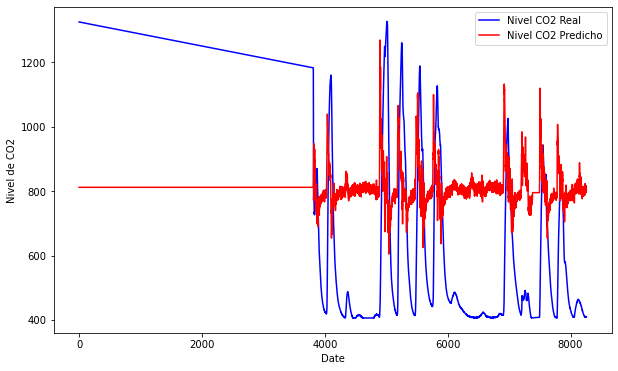

In [51]:
rmse_lr_5_co2, mae_lr_5_co2, preds_lr_5_co2 = testCO2Quality(df_lags_5, 5, LinearRegression())

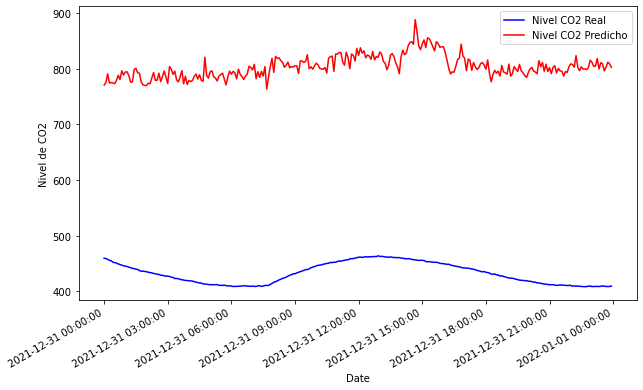

In [52]:
# Create figure and plot space
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot_date(df_final.index[27240:], df_final.co2[27240:], 'b-', color='blue', label='Nivel CO2 Real')
ax.plot_date(df_final.index[27240:], preds_lr_5_co2[4][7969:], 'b-', color='red', label='Nivel CO2 Predicho')

ax.set(xlabel="Date",
       ylabel="Nivel de CO2")

ax.legend()

# Define the date format
date_form = mdates.DateFormatter("%Y-%m-%d %H:%M:%S")
ax.xaxis.set_major_formatter(date_form)
fig.autofmt_xdate()

plt.show()

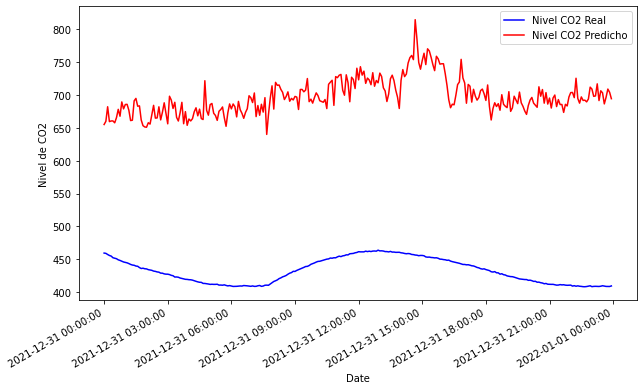

In [53]:
# Create figure and plot space
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot_date(df_final.index[27240:], df_final.co2[27240:], 'b-', color='blue', label='Nivel CO2 Real')
ax.plot_date(df_final.index[27240:], preds_lr_5_co2[0][7969:], 'b-', color='red', label='Nivel CO2 Predicho')

ax.set(xlabel="Date",
       ylabel="Nivel de CO2")

ax.legend()

# Define the date format
date_form = mdates.DateFormatter("%Y-%m-%d %H:%M:%S")
ax.xaxis.set_major_formatter(date_form)
fig.autofmt_xdate()

plt.show()

# PM2.5

In [54]:
# Realiza las prediciones recursivas a h pasos
def recursiveStepsAhead(X_test, y_test, nSteps, scaler, model):
    prueba_X_test = X_test.copy()
    testPredRMSE, testPredMAE = [], []
    preds = []

    testPredict = model.predict(prueba_X_test)
    lagspm25 = np.sum([len(re.findall("Lag_pm25*", i)) for i in X_test.columns])
    
    for p in range(nSteps):
        prueba_X_test = pd.concat([prueba_X_test.iloc[:,:-lagspm25], prueba_X_test.iloc[:,-lagspm25:].shift(1, axis = 1) ], axis=1)
        prueba_X_test['Lag_pm25_' + str(1)] = testPredict
        
        testPredict = model.predict(prueba_X_test)

        # invert predictions
        testPredict_transform = scaler.inverse_transform(testPredict.reshape(-1, 1))
        y_test_transform = scaler.inverse_transform(y_test.to_numpy())

        # calculate root mean squared error
        rmse = math.sqrt(mean_squared_error(y_test_transform, testPredict_transform.ravel()))
        mae = mean_absolute_error(y_test_transform, testPredict_transform.ravel())
        
        testPredRMSE.append(rmse)
        testPredMAE.append(mae)
        
        preds.append(testPredict_transform)
        print('Test Score Step %d' % (p+1))
        print('RMSE %.2f' % (rmse))
        print('MAE %.2f' % (mae))
        
    return testPredRMSE, testPredMAE, preds

In [55]:
def testPM25Quality(df, nSteps, model):
    # normalize the dataset
    scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
    df_norm = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

    X_train, X_test, y_train, y_test = train_test_split(df_norm.iloc[:,:-1], df_norm.iloc[:,-1:], 
                                                        test_size=0.3, 
                                                        random_state=seed_value,
                                                       shuffle=False)

    # train the model
    random.seed(seed)
    model = model.fit(X_train, y_train.to_numpy().ravel())

    scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
    scaler.fit_transform(df['pm25'].to_numpy().reshape(-1, 1))

    # recursive steps ahead predictions
    rmse, mae, preds = recursiveStepsAhead(X_test, y_test, nSteps, scaler, model)
    
    y_test_transformed = scaler.inverse_transform(y_test.to_numpy())
    
    # plot results
    plt.figure(figsize=(10,6))
    plt.plot(y_test_transformed, color='blue', label='Nivel PM2.5 Real')
    plt.plot(preds[nSteps-1] , color='red', label='Nivel PM2.5 Predicho')
    plt.xlabel('Date')
    plt.ylabel('Nivel de PM2.5')
    plt.legend()
    plt.show()
    
    return rmse, mae, preds

In [62]:
df_final_pm25 = df_final[['temperature', 'relativehumidity', 'pm10', 'co2', 'pm25']]

In [63]:
intervalos = pd.DataFrame(index=pd.date_range('2021-09-27 10:00:00', '2021-12-31 23:55:00', freq='5T')).reset_index(level=0)
intervalos.rename(columns = {'index':'time_index'}, inplace = True)
intervalos

,time_index
0,2021-09-27 10:00:00
1,2021-09-27 10:05:00
2,2021-09-27 10:10:00
3,2021-09-27 10:15:00
4,2021-09-27 10:20:00
...,...
27523,2021-12-31 23:35:00
27524,2021-12-31 23:40:00
27525,2021-12-31 23:45:00
27526,2021-12-31 23:50:00


In [64]:
df_final_pm25 = df_final_pm25.reset_index(level=0)
df_final_pm25 = pd.merge(df_final_pm25, intervalos, on='time_index', how='right')
df_final_pm25 = df_final_pm25.interpolate(method ='linear', limit_direction ='forward')
df_final_pm25 = df_final_pm25.set_index('time_index')
df_final_pm25

,temperature,relativehumidity,pm10,co2,pm25
time_index,,,,,
2021-09-27 10:00:00,27.340,49.740,13.00,594.850,11.880
2021-09-27 10:05:00,27.404,49.682,11.95,594.034,10.854
2021-09-27 10:10:00,27.468,49.624,10.90,593.218,9.828
2021-09-27 10:15:00,27.532,49.566,9.85,592.402,8.802
2021-09-27 10:20:00,27.596,49.508,8.80,591.586,7.776
...,...,...,...,...,...
2021-12-31 23:35:00,18.810,50.120,20.40,409.350,19.400
2021-12-31 23:40:00,18.820,50.130,20.80,408.840,19.800
2021-12-31 23:45:00,18.780,50.070,21.80,408.720,20.800


In [65]:
df_lags_5_pm25 = lags(df_final_pm25, 5) #predecir a 5 minutos
df_lags_5_pm25 = df_lags_5_pm25.iloc[5:,:].reset_index(drop=True)
df_lags_5_pm25

,temperature,relativehumidity,pm10,co2,pm25,Lag_temperature_1,Lag_temperature_2,Lag_temperature_3,Lag_temperature_4,Lag_temperature_5,...,Lag_co2_1,Lag_co2_2,Lag_co2_3,Lag_co2_4,Lag_co2_5,Lag_pm25_1,Lag_pm25_2,Lag_pm25_3,Lag_pm25_4,Lag_pm25_5
0,27.66,49.45,7.75,590.77,6.75,27.596,27.532,27.468,27.404,27.340,...,591.586,592.402,593.218,594.034,594.850,7.776,8.802,9.828,10.854,11.880
1,27.94,49.70,6.38,578.66,5.38,27.660,27.596,27.532,27.468,27.404,...,590.770,591.586,592.402,593.218,594.034,6.750,7.776,8.802,9.828,10.854
2,28.03,48.59,5.71,581.25,4.71,27.940,27.660,27.596,27.532,27.468,...,578.660,590.770,591.586,592.402,593.218,5.380,6.750,7.776,8.802,9.828
3,28.09,48.43,4.62,586.75,3.62,28.030,27.940,27.660,27.596,27.532,...,581.250,578.660,590.770,591.586,592.402,4.710,5.380,6.750,7.776,8.802
4,28.06,48.02,4.62,579.95,3.62,28.090,28.030,27.940,27.660,27.596,...,586.750,581.250,578.660,590.770,591.586,3.620,4.710,5.380,6.750,7.776
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27518,18.81,50.12,20.40,409.35,19.40,18.820,18.820,18.830,18.860,18.870,...,409.860,409.150,408.770,408.920,409.000,19.100,18.700,18.100,17.500,17.500
27519,18.82,50.13,20.80,408.84,19.80,18.810,18.820,18.820,18.830,18.860,...,409.350,409.860,409.150,408.770,408.920,19.400,19.100,18.700,18.100,17.500
27520,18.78,50.07,21.80,408.72,20.80,18.820,18.810,18.820,18.820,18.830,...,408.840,409.350,409.860,409.150,408.770,19.800,19.400,19.100,18.700,18.100
27521,18.79,50.10,21.40,408.75,20.40,18.780,18.820,18.810,18.820,18.820,...,408.720,408.840,409.350,409.860,409.150,20.800,19.800,19.400,19.100,18.700


In [66]:
df_lags_5_pm25 = dfIncrementos(df_lags_5_pm25, 5)
df_lags_5_pm25

,Lag_temperature_1,Lag_temperature_2,Lag_temperature_3,Lag_temperature_4,Lag_temperature_5,Lag_relativehumidity_1,Lag_relativehumidity_2,Lag_relativehumidity_3,Lag_relativehumidity_4,Lag_relativehumidity_5,...,Lag_co2_2,Lag_co2_3,Lag_co2_4,Lag_co2_5,Lag_pm25_1,Lag_pm25_2,Lag_pm25_3,Lag_pm25_4,Lag_pm25_5,pm25
0,0.064,0.128,0.192,0.256,0.320,-0.058,-0.116,-0.174,-0.232,-0.290,...,-1.632,-2.448,-3.264,-4.080,-1.026,-2.052,-3.078,-4.104,-5.130,6.75
1,0.280,0.344,0.408,0.472,0.536,0.250,0.192,0.134,0.076,0.018,...,-12.926,-13.742,-14.558,-15.374,-1.370,-2.396,-3.422,-4.448,-5.474,5.38
2,0.090,0.370,0.434,0.498,0.562,-1.110,-0.860,-0.918,-0.976,-1.034,...,-9.520,-10.336,-11.152,-11.968,-0.670,-2.040,-3.066,-4.092,-5.118,4.71
3,0.060,0.150,0.430,0.494,0.558,-0.160,-1.270,-1.020,-1.078,-1.136,...,8.090,-4.020,-4.836,-5.652,-1.090,-1.760,-3.130,-4.156,-5.182,3.62
4,-0.030,0.030,0.120,0.400,0.464,-0.410,-0.570,-1.680,-1.430,-1.488,...,-1.300,1.290,-10.820,-11.636,0.000,-1.090,-1.760,-3.130,-4.156,3.62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27518,-0.010,-0.010,-0.020,-0.050,-0.060,0.050,0.060,0.050,0.040,0.060,...,0.200,0.580,0.430,0.350,0.300,0.700,1.300,1.900,1.900,19.40
27519,0.010,0.000,0.000,-0.010,-0.040,0.010,0.060,0.070,0.060,0.050,...,-1.020,-0.310,0.070,-0.080,0.400,0.700,1.100,1.700,2.300,19.80
27520,-0.040,-0.030,-0.040,-0.040,-0.050,-0.060,-0.050,0.000,0.010,0.000,...,-0.630,-1.140,-0.430,-0.050,1.000,1.400,1.700,2.100,2.700,20.80
27521,0.010,-0.030,-0.020,-0.030,-0.030,0.030,-0.030,-0.020,0.030,0.040,...,-0.090,-0.600,-1.110,-0.400,-0.400,0.600,1.000,1.300,1.700,20.40


## Linear Regression

Test Score Step 1
RMSE 65.09
MAE 64.99
Test Score Step 2
RMSE 266.92
MAE 266.88
Test Score Step 3
RMSE 888.77
MAE 888.71
Test Score Step 4
RMSE 2853.22
MAE 2853.05
Test Score Step 5
RMSE 9027.47
MAE 9026.95


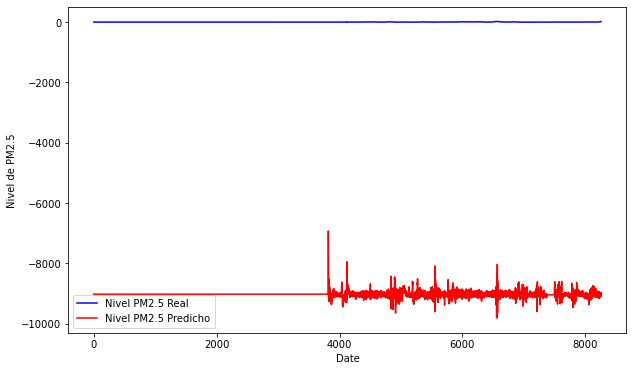

In [67]:
rmse_lr_5_pm25, mae_lr_5_pm25, preds_lr_5_pm25 = testPM25Quality(df_lags_5_pm25, 5, LinearRegression())

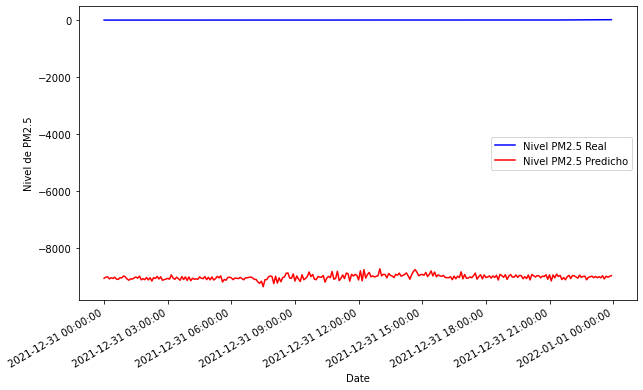

In [68]:
# Create figure and plot space
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot_date(df_final_pm25.index[27240:], df_final_pm25.pm25[27240:], 'b-', color='blue', label='Nivel PM2.5 Real')
ax.plot_date(df_final_pm25.index[27240:], preds_lr_5_pm25[4][7969:], 'b-', color='red', label='Nivel PM2.5 Predicho')

ax.set(xlabel="Date",
       ylabel="Nivel de PM2.5")

ax.legend()

# Define the date format
date_form = mdates.DateFormatter("%Y-%m-%d %H:%M:%S")
ax.xaxis.set_major_formatter(date_form)
fig.autofmt_xdate()

plt.show()

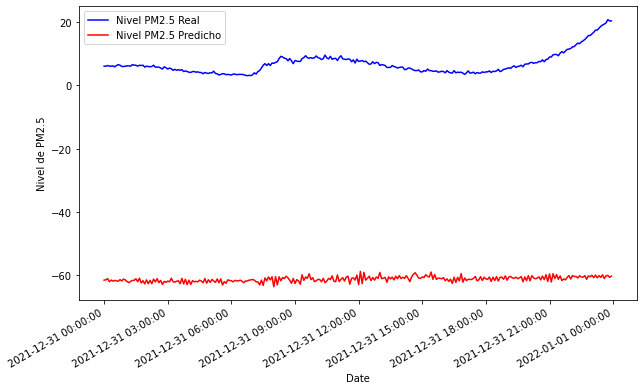

In [69]:
# Create figure and plot space
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot_date(df_final_pm25.index[27240:], df_final_pm25.pm25[27240:], 'b-', color='blue', label='Nivel PM2.5 Real')
ax.plot_date(df_final_pm25.index[27240:], preds_lr_5_pm25[0][7969:], 'b-', color='red', label='Nivel PM2.5 Predicho')

ax.set(xlabel="Date",
       ylabel="Nivel de PM2.5")

ax.legend()

# Define the date format
date_form = mdates.DateFormatter("%Y-%m-%d %H:%M:%S")
ax.xaxis.set_major_formatter(date_form)
fig.autofmt_xdate()

plt.show()

# PM10

In [70]:
# Realiza las prediciones recursivas a h pasos
def recursiveStepsAhead(X_test, y_test, nSteps, scaler, model):
    prueba_X_test = X_test.copy()
    testPredRMSE, testPredMAE = [], []
    preds = []

    testPredict = model.predict(prueba_X_test)
    lagspm10 = np.sum([len(re.findall("Lag_pm10*", i)) for i in X_test.columns])
    
    for p in range(nSteps):
        prueba_X_test = pd.concat([prueba_X_test.iloc[:,:-lagspm10], prueba_X_test.iloc[:,-lagspm10:].shift(1, axis = 1) ], axis=1)
        prueba_X_test['Lag_pm10_' + str(1)] = testPredict
        
        testPredict = model.predict(prueba_X_test)

        # invert predictions
        testPredict_transform = scaler.inverse_transform(testPredict.reshape(-1, 1))
        y_test_transform = scaler.inverse_transform(y_test.to_numpy())

        # calculate root mean squared error
        rmse = math.sqrt(mean_squared_error(y_test_transform, testPredict_transform.ravel()))
        mae = mean_absolute_error(y_test_transform, testPredict_transform.ravel())
        
        testPredRMSE.append(rmse)
        testPredMAE.append(mae)
        
        preds.append(testPredict_transform)
        print('Test Score Step %d' % (p+1))
        print('RMSE %.2f' % (rmse))
        print('MAE %.2f' % (mae))
        
    return testPredRMSE, testPredMAE, preds

In [71]:
def testPM10Quality(df, nSteps, model):
    # normalize the dataset
    scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
    df_norm = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

    X_train, X_test, y_train, y_test = train_test_split(df_norm.iloc[:,:-1], df_norm.iloc[:,-1:], 
                                                        test_size=0.3, 
                                                        random_state=seed_value,
                                                       shuffle=False)

    # train the model
    random.seed(seed)
    model = model.fit(X_train, y_train.to_numpy().ravel())

    scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
    scaler.fit_transform(df['pm10'].to_numpy().reshape(-1, 1))

    # recursive steps ahead predictions
    rmse, mae, preds = recursiveStepsAhead(X_test, y_test, nSteps, scaler, model)
    
    y_test_transformed = scaler.inverse_transform(y_test.to_numpy())
    
    # plot results
    plt.figure(figsize=(10,6))
    plt.plot(y_test_transformed, color='blue', label='Nivel PM10 Real')
    plt.plot(preds[nSteps-1] , color='red', label='Nivel PM10 Predicho')
    plt.xlabel('Date')
    plt.ylabel('Nivel de PM10')
    plt.legend()
    plt.show()
    
    return rmse, mae, preds

In [72]:
df_final_pm10 = df_final[['temperature', 'relativehumidity', 'pm25', 'co2', 'pm10']]

In [73]:
intervalos = pd.DataFrame(index=pd.date_range('2021-09-27 10:00:00', '2021-12-31 23:55:00', freq='5T')).reset_index(level=0)
intervalos.rename(columns = {'index':'time_index'}, inplace = True)
intervalos

,time_index
0,2021-09-27 10:00:00
1,2021-09-27 10:05:00
2,2021-09-27 10:10:00
3,2021-09-27 10:15:00
4,2021-09-27 10:20:00
...,...
27523,2021-12-31 23:35:00
27524,2021-12-31 23:40:00
27525,2021-12-31 23:45:00
27526,2021-12-31 23:50:00


In [74]:
df_final_pm10 = df_final_pm10.reset_index(level=0)
df_final_pm10 = pd.merge(df_final_pm10, intervalos, on='time_index', how='right')
df_final_pm10 = df_final_pm10.interpolate(method ='linear', limit_direction ='forward')
df_final_pm10 = df_final_pm10.set_index('time_index')
df_final_pm10

,temperature,relativehumidity,pm25,co2,pm10
time_index,,,,,
2021-09-27 10:00:00,27.340,49.740,11.880,594.850,13.00
2021-09-27 10:05:00,27.404,49.682,10.854,594.034,11.95
2021-09-27 10:10:00,27.468,49.624,9.828,593.218,10.90
2021-09-27 10:15:00,27.532,49.566,8.802,592.402,9.85
2021-09-27 10:20:00,27.596,49.508,7.776,591.586,8.80
...,...,...,...,...,...
2021-12-31 23:35:00,18.810,50.120,19.400,409.350,20.40
2021-12-31 23:40:00,18.820,50.130,19.800,408.840,20.80
2021-12-31 23:45:00,18.780,50.070,20.800,408.720,21.80


In [75]:
df_lags_5_pm10 = lags(df_final_pm10, 5) #predecir a 5 minutos
df_lags_5_pm10 = df_lags_5_pm10.iloc[5:,:].reset_index(drop=True)
df_lags_5_pm10

,temperature,relativehumidity,pm25,co2,pm10,Lag_temperature_1,Lag_temperature_2,Lag_temperature_3,Lag_temperature_4,Lag_temperature_5,...,Lag_co2_1,Lag_co2_2,Lag_co2_3,Lag_co2_4,Lag_co2_5,Lag_pm10_1,Lag_pm10_2,Lag_pm10_3,Lag_pm10_4,Lag_pm10_5
0,27.66,49.45,6.75,590.77,7.75,27.596,27.532,27.468,27.404,27.340,...,591.586,592.402,593.218,594.034,594.850,8.80,9.85,10.90,11.95,13.00
1,27.94,49.70,5.38,578.66,6.38,27.660,27.596,27.532,27.468,27.404,...,590.770,591.586,592.402,593.218,594.034,7.75,8.80,9.85,10.90,11.95
2,28.03,48.59,4.71,581.25,5.71,27.940,27.660,27.596,27.532,27.468,...,578.660,590.770,591.586,592.402,593.218,6.38,7.75,8.80,9.85,10.90
3,28.09,48.43,3.62,586.75,4.62,28.030,27.940,27.660,27.596,27.532,...,581.250,578.660,590.770,591.586,592.402,5.71,6.38,7.75,8.80,9.85
4,28.06,48.02,3.62,579.95,4.62,28.090,28.030,27.940,27.660,27.596,...,586.750,581.250,578.660,590.770,591.586,4.62,5.71,6.38,7.75,8.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27518,18.81,50.12,19.40,409.35,20.40,18.820,18.820,18.830,18.860,18.870,...,409.860,409.150,408.770,408.920,409.000,20.10,19.70,19.10,18.50,18.50
27519,18.82,50.13,19.80,408.84,20.80,18.810,18.820,18.820,18.830,18.860,...,409.350,409.860,409.150,408.770,408.920,20.40,20.10,19.70,19.10,18.50
27520,18.78,50.07,20.80,408.72,21.80,18.820,18.810,18.820,18.820,18.830,...,408.840,409.350,409.860,409.150,408.770,20.80,20.40,20.10,19.70,19.10
27521,18.79,50.10,20.40,408.75,21.40,18.780,18.820,18.810,18.820,18.820,...,408.720,408.840,409.350,409.860,409.150,21.80,20.80,20.40,20.10,19.70


In [76]:
df_lags_5_pm10 = dfIncrementos(df_lags_5_pm10, 5)
df_lags_5_pm10

,Lag_temperature_1,Lag_temperature_2,Lag_temperature_3,Lag_temperature_4,Lag_temperature_5,Lag_relativehumidity_1,Lag_relativehumidity_2,Lag_relativehumidity_3,Lag_relativehumidity_4,Lag_relativehumidity_5,...,Lag_co2_2,Lag_co2_3,Lag_co2_4,Lag_co2_5,Lag_pm10_1,Lag_pm10_2,Lag_pm10_3,Lag_pm10_4,Lag_pm10_5,pm10
0,0.064,0.128,0.192,0.256,0.320,-0.058,-0.116,-0.174,-0.232,-0.290,...,-1.632,-2.448,-3.264,-4.080,-1.05,-2.10,-3.15,-4.20,-5.25,7.75
1,0.280,0.344,0.408,0.472,0.536,0.250,0.192,0.134,0.076,0.018,...,-12.926,-13.742,-14.558,-15.374,-1.37,-2.42,-3.47,-4.52,-5.57,6.38
2,0.090,0.370,0.434,0.498,0.562,-1.110,-0.860,-0.918,-0.976,-1.034,...,-9.520,-10.336,-11.152,-11.968,-0.67,-2.04,-3.09,-4.14,-5.19,5.71
3,0.060,0.150,0.430,0.494,0.558,-0.160,-1.270,-1.020,-1.078,-1.136,...,8.090,-4.020,-4.836,-5.652,-1.09,-1.76,-3.13,-4.18,-5.23,4.62
4,-0.030,0.030,0.120,0.400,0.464,-0.410,-0.570,-1.680,-1.430,-1.488,...,-1.300,1.290,-10.820,-11.636,0.00,-1.09,-1.76,-3.13,-4.18,4.62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27518,-0.010,-0.010,-0.020,-0.050,-0.060,0.050,0.060,0.050,0.040,0.060,...,0.200,0.580,0.430,0.350,0.30,0.70,1.30,1.90,1.90,20.40
27519,0.010,0.000,0.000,-0.010,-0.040,0.010,0.060,0.070,0.060,0.050,...,-1.020,-0.310,0.070,-0.080,0.40,0.70,1.10,1.70,2.30,20.80
27520,-0.040,-0.030,-0.040,-0.040,-0.050,-0.060,-0.050,0.000,0.010,0.000,...,-0.630,-1.140,-0.430,-0.050,1.00,1.40,1.70,2.10,2.70,21.80
27521,0.010,-0.030,-0.020,-0.030,-0.030,0.030,-0.030,-0.020,0.030,0.040,...,-0.090,-0.600,-1.110,-0.400,-0.40,0.60,1.00,1.30,1.70,21.40


## Linear Regression

Test Score Step 1
RMSE 61.93
MAE 61.84
Test Score Step 2
RMSE 12.93
MAE 12.43
Test Score Step 3
RMSE 30.15
MAE 29.92
Test Score Step 4
RMSE 90.18
MAE 90.08
Test Score Step 5
RMSE 219.93
MAE 219.87


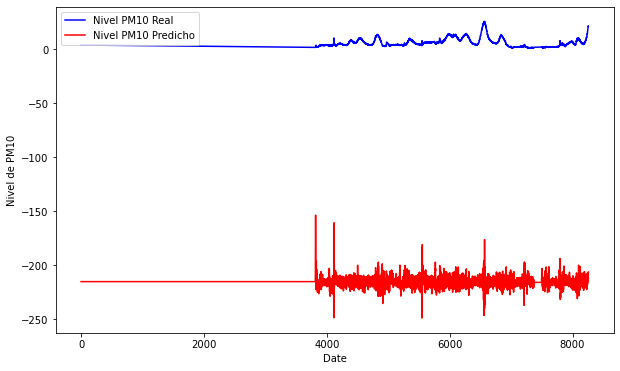

In [77]:
rmse_lr_5_pm10, mae_lr_5_pm10, preds_lr_5_pm10 = testPM10Quality(df_lags_5_pm10, 5, LinearRegression())

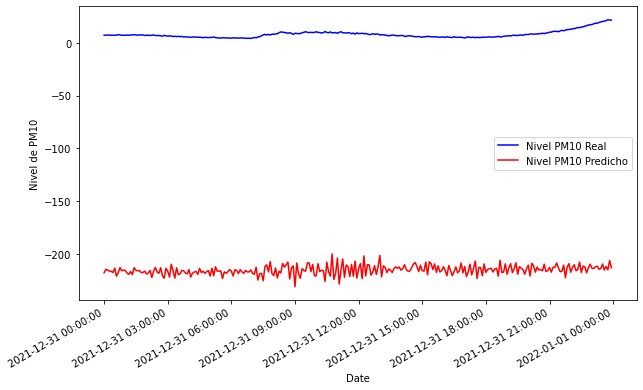

In [78]:
# Create figure and plot space
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot_date(df_final_pm10.index[27240:], df_final_pm10.pm10[27240:], 'b-', color='blue', label='Nivel PM10 Real')
ax.plot_date(df_final_pm10.index[27240:], preds_lr_5_pm10[4][7969:], 'b-', color='red', label='Nivel PM10 Predicho')

ax.set(xlabel="Date",
       ylabel="Nivel de PM10")

ax.legend()

# Define the date format
date_form = mdates.DateFormatter("%Y-%m-%d %H:%M:%S")
ax.xaxis.set_major_formatter(date_form)
fig.autofmt_xdate()

plt.show()